In [161]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, GRU, Dense, Dropout, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf


In [162]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    labels = data['label'].values
    labels = labels.astype(int)
    features = data.drop(columns=['label']).values
    return features, labels

# Đọc dữ liệu từ các tệp CSV
X_train, y_train = load_data("dataset/train.csv")
X_test, y_test = load_data("dataset/test.csv")
X_val, y_val = load_data("dataset/validation.csv")

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Định hình lại dữ liệu để phù hợp với đầu vào của GRU
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)

# Chuyển đổi nhãn thành định dạng one-hot
encoder = OneHotEncoder(sparse_output=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))
y_val = encoder.transform(y_val.reshape(-1, 1))

print("\n")
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_val shape:", y_val.shape)

X_train shape: (17412, 1, 36)
X_test shape: (4052, 1, 36)
X_val shape: (5352, 1, 36)


y_train shape: (17412, 6)
y_test shape: (4052, 6)
y_val shape: (5352, 6)


In [163]:
# Định nghĩa lớp Attention
@tf.keras.utils.register_keras_serializable(package='Custom', name='Attention')
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)


In [164]:
from sklearn.utils.class_weight import compute_class_weight

# Danh sách các nhãn
class_labels = np.unique(np.argmax(y_train, axis=1))  # Các class có trong y_train

# Tính trọng số class weight
class_weights = compute_class_weight('balanced', classes=class_labels, y=np.argmax(y_train, axis=1))
class_weights_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.601700186605847, 1: 0.7697612732095491, 2: 0.7606815203145478, 3: 1.3747039317858836, 4: 1.9372496662216288, 5: 2.0802867383512544}


In [165]:
# Xây dựng mô hình Bi-GRU với Attention

# Input layer
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# GRU layer
gru_layer = Bidirectional(GRU(64, return_sequences=True, kernel_regularizer='l2'))(input_layer)

# Attention layer
attention_layer = Attention()(gru_layer)

# Dropout layer
dropout_layer = Dropout(0.5)(attention_layer)

# Output layer
output_layer = Dense(y_train.shape[1], activation='softmax')(dropout_layer)

# Khai báo learning rate
optimizer = Adam(learning_rate=0.001) 

# Callback để lưu checkpoint
checkpoint = ModelCheckpoint("Model/Squat_detection_GRU.keras", save_best_only=True, monitor="val_loss", mode="min")

#early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Build model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_38 (InputLayer)     │ (None, 1, 36)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_38                │ (None, 1, 128)         │        39,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_37 (Attention)        │ (None, 128)            │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,071 (156.53 KB)

 Trainable params: 40,071 (156.53 KB)

 Non-trainable params: 0 (0.00 B)

In [166]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, 
                    epochs=1000, 
                    batch_size=128, 
                    validation_data=(X_val, y_val), 
                    class_weight=class_weights_dict, 
                    callbacks=[checkpoint, early_stopping])
# Đánh giá mô hình
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')


Epoch 1/1000
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4637 - loss: 2.1306 - val_accuracy: 0.7696 - val_loss: 1.0352
Epoch 2/1000
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8770 - loss: 0.7357 - val_accuracy: 0.8705 - val_loss: 0.6636
Epoch 3/1000
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9343 - loss: 0.4792 - val_accuracy: 0.8933 - val_loss: 0.5337
Epoch 4/1000
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9526 - loss: 0.3764 - val_accuracy: 0.8950 - val_loss: 0.4789
Epoch 5/1000
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9613 - loss: 0.3191 - val_accuracy: 0.9094 - val_loss: 0.4170
Epoch 6/1000
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.2798 - val_accuracy: 0.9172 - val_loss: 0.4077
Epoch 7/1000
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9677 - loss: 0.2612 - val_accuracy: 0.9359 - val_loss: 0.3546
Epoch 8/1000
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9703 - loss: 0.2387 - 

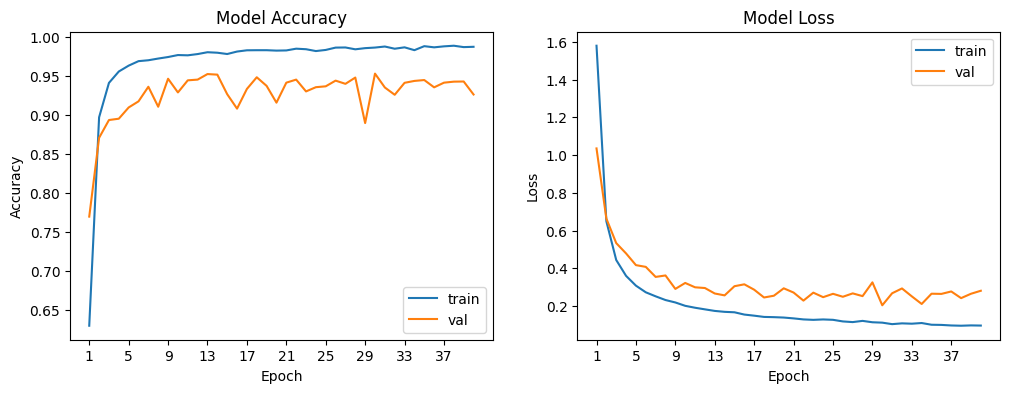

<Figure size 640x480 with 0 Axes>

In [167]:
# Tiếp theo ta plot các thông số loss và acc ra
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Vẽ Accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'])
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    
    # Sửa lỗi ở đây
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1, step=max(1, len(model_history.history['accuracy']) // 10)))

    axs[0].legend(['train', 'val'], loc='best')

    # Vẽ Loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1, step=max(1, len(model_history.history['loss']) // 10)))

    axs[1].legend(['train', 'val'], loc='best')
    
    plt.show()
    plt.savefig('roc.png')

# Gọi hàm
plot_model_history(history)

In [168]:
from sklearn.metrics import classification_report

# Chuyển đổi y_test từ one-hot encoded về dạng số
true_labels = np.argmax(y_test, axis=1)

# Dự đoán xác suất cho các lớp
y_pred = model.predict(X_test)

# Chọn nhãn có xác suất cao nhất
predicted_labels = np.argmax(y_pred, axis=1)

# Tính toán và in ra báo cáo phân loại
report = classification_report(true_labels, predicted_labels, target_names=[str(i) for i in range(y_test.shape[1])])
print(report)

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1139
           1       1.00      0.81      0.90       924
           2       1.00      1.00      1.00       934
           3       0.67      1.00      0.80       369
           4       0.71      0.96      0.82       325
           5       0.99      0.93      0.96       361

    accuracy                           0.92      4052
   macro avg       0.89      0.93      0.90      4052
weighted avg       0.94      0.92      0.92      4052



In [ ]:
import pickle

with open("Model/scaler_GRU.pkl", "wb") as f:
    pickle.dump(scaler, f)  # Lưu scaler vào file scaler.pkl